### **Decision Tree and Random Forest**

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jsphyg/weather-dataset-rattle-package")

print("Path to dataset files:", path)

C:\Users\HELWA\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\HELWA\.cache\kagglehub\datasets\jsphyg\weather-dataset-rattle-package\versions\2


In [2]:
import pandas as pd
import os

# Tentukan nama file (dataset ini biasanya bernama weatherAUS.csv)
file_name = "weatherAUS.csv"
full_path = os.path.join(path, file_name)

# Baca file CSV
raw_df = pd.read_csv(full_path)

# Intip 5 data teratas
print(raw_df.head())

# Cek info kolom dan tipe data
print(raw_df.info())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

## **Preparing the Data for Training**
**Training, Validation, and Test Sets**

<Axes: title={'center': 'No. of Rows per Year'}, xlabel='Date', ylabel='count'>

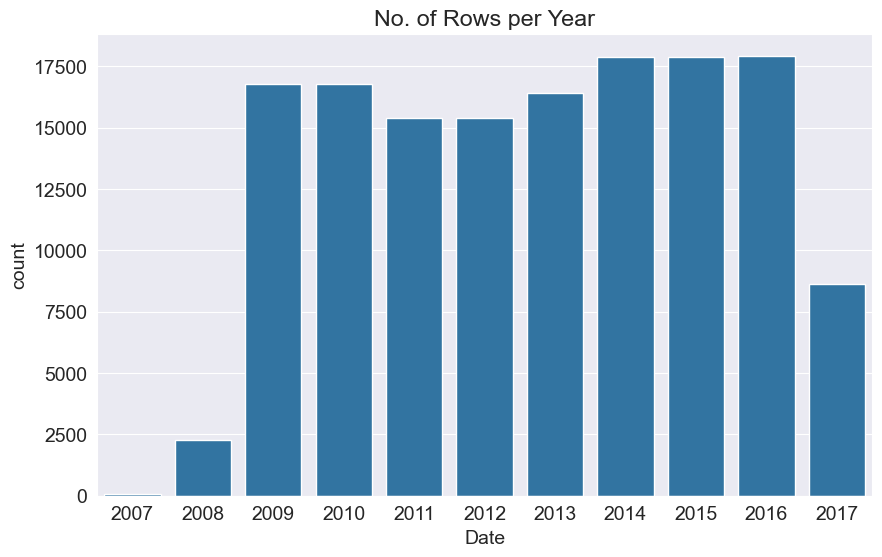

In [5]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year)

In [ ]:
# Memisahkan data menjadi 3 bagian yaitu training, validation, dan testing
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [7]:
print('train_df: ', train_df.shape)
print('val_df: ', val_df.shape)
print('test_df: ', test_df.shape)

train_df:  (101018, 23)
val_df:  (17885, 23)
test_df:  (26557, 23)


**Input and Target Columns**

In [8]:
input_cols = list(train_df.columns) [1:-1]
target_col = 'RainTomorrow'

In [9]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [10]:
val_inputs = train_df[input_cols].copy()
val_targets = train_df[target_col].copy()

In [11]:
test_inputs = train_df[input_cols].copy()
test_targets = train_df[target_col].copy()

In [12]:
# Identifikasi numeric and categorical colums
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [13]:
print(numeric_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [14]:
print(categorical_cols)

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


**Imputing Missing Numeric Values**

In [15]:
from sklearn.impute import SimpleImputer

In [16]:
imputer = SimpleImputer(strategy='mean').fit(raw_df[numeric_cols])

In [17]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [18]:
test_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

**Scalling Numeric Features**

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [21]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [22]:
val_inputs.describe().loc[['min', 'max']]

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
min      0.0  0.013233       0.0     0.000000  0.000000            0.0   
max      1.0  1.000000       1.0     0.568276  0.986207            1.0   

     WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
min      0.000000           0.0          0.0          0.0          0.0   
max      0.669231           1.0          1.0          1.0          1.0   

     Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  
min       0.0304       0.0       0.0  0.027426  0.005758  
max       1.0000       1.0       1.0  1.000000  0.988484

**Encoding Categorical Data**

In [23]:
from sklearn.preprocessing import OneHotEncoder

In [25]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(raw_df[categorical_cols])

In [26]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [27]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

C:\Users\HELWA\AppData\Local\Temp\ipykernel_3568\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\HELWA\AppData\Local\Temp\ipykernel_3568\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\HELWA\AppData\Local\Temp\ipykernel_3568\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [28]:
test_inputs

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
0        Albury  0.516509  0.523629  0.001617     0.037712  0.524909   
1        Albury  0.375000  0.565217  0.000000     0.037712  0.524909   
2        Albury  0.504717  0.576560  0.000000     0.037712  0.524909   
3        Albury  0.417453  0.620038  0.000000     0.037712  0.524909   
4        Albury  0.613208  0.701323  0.002695     0.037712  0.524909   
...         ...       ...       ...       ...          ...       ...   
144548    Uluru  0.599057  0.718336  0.000000     0.037712  0.524909   
144549    Uluru  0.556604  0.786389  0.000000     0.037712  0.524909   
144550    Uluru  0.608491  0.805293  0.000000     0.037712  0.524909   
144551    Uluru  0.674528  0.818526  0.000000     0.037712  0.524909   
144552    Uluru  0.731132  0.839319  0.000000     0.037712  0.524909   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0                W       0.294574          W        WNW      0.153846   
1              WNW       0.294574        NNW        WSW      0.030769   
2              WSW       0.310078          W        WSW      0.146154   
3               NE       0.139535         SE          E      0.084615   
4                W       0.271318        ENE         NW      0.053846   
...            ...            ...        ...        ...           ...   
144548         SSE       0.286822        ESE        SSE      0.184615   
144549          NE       0.193798        ENE         SW      0.146154   
144550         ESE       0.255814        ESE        SSE      0.200000   
144551         ESE       0.286822        ESE        SSW      0.215385   
144552         WNW       0.542636        ENE        SSW      0.230769   

        WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  \
0           0.275862         0.71         0.22     0.449587       0.4800   
1           0.252874         0.44         0.25     0.497521       0.4912   
2           0.298851         0.38         0.30     0.447934       0.5056   
3           0.103448         0.45         0.16     0.613223       0.5712   
4           0.229885         0.82         0.33     0.500826       0.4624   
...              ...          ...          ...          ...          ...   
144548      0.298851         0.22         0.13     0.555372       0.5232   
144549      0.229885         0.16         0.08     0.530579       0.4880   
144550      0.103448         0.15         0.08     0.519008       0.4944   
144551      0.195402         0.22         0.09     0.553719       0.5136   
144552      0.149425         0.16         0.09     0.522314       0.4656   

        Cloud9am  Cloud3pm   Temp9am   Temp3pm RainToday  Location_Adelaide  \
0       0.888889  0.501103  0.508439  0.522073        No                0.0   
1       0.494162  0.501103  0.514768  0.570058        No                0.0   
2       0.494162  0.222222  0.594937  0.548944        No                0.0   
3       0.494162  0.501103  0.533755  0.612284        No                0.0   
4       0.777778  0.888889  0.527426  0.673704        No                0.0   
...          ...       ...       ...       ...       ...                ...   
144548  0.494162  0.501103  0.651899  0.714012        No                0.0   
144549  0.494162  0.501103  0.761603  0.771593        No                0.0   
144550  0.494162  0.501103  0.778481  0.788868        No                0.0   
144551  0.494162  0.501103  0.780591  0.817658        No                0.0   
144552  0.494162  0.501103  0.786920  0.821497        No                0.0   

        Location_Albany  Location_Albury  Location_AliceSprings  \
0                   0.0              1.0                    0.0   
1                   0.0              1.0                    0.0   
2                   0.0              1.0                    0.0   
3                   0.0              1.0                    0.0   
4                   0.0              1.0                    0.0   
.

In [29]:
val_inputs

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
0        Albury  0.516509  0.523629  0.001617     0.037712  0.524909   
1        Albury  0.375000  0.565217  0.000000     0.037712  0.524909   
2        Albury  0.504717  0.576560  0.000000     0.037712  0.524909   
3        Albury  0.417453  0.620038  0.000000     0.037712  0.524909   
4        Albury  0.613208  0.701323  0.002695     0.037712  0.524909   
...         ...       ...       ...       ...          ...       ...   
144548    Uluru  0.599057  0.718336  0.000000     0.037712  0.524909   
144549    Uluru  0.556604  0.786389  0.000000     0.037712  0.524909   
144550    Uluru  0.608491  0.805293  0.000000     0.037712  0.524909   
144551    Uluru  0.674528  0.818526  0.000000     0.037712  0.524909   
144552    Uluru  0.731132  0.839319  0.000000     0.037712  0.524909   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0                W       0.294574          W        WNW      0.153846   
1              WNW       0.294574        NNW        WSW      0.030769   
2              WSW       0.310078          W        WSW      0.146154   
3               NE       0.139535         SE          E      0.084615   
4                W       0.271318        ENE         NW      0.053846   
...            ...            ...        ...        ...           ...   
144548         SSE       0.286822        ESE        SSE      0.184615   
144549          NE       0.193798        ENE         SW      0.146154   
144550         ESE       0.255814        ESE        SSE      0.200000   
144551         ESE       0.286822        ESE        SSW      0.215385   
144552         WNW       0.542636        ENE        SSW      0.230769   

        WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  \
0           0.275862         0.71         0.22     0.449587       0.4800   
1           0.252874         0.44         0.25     0.497521       0.4912   
2           0.298851         0.38         0.30     0.447934       0.5056   
3           0.103448         0.45         0.16     0.613223       0.5712   
4           0.229885         0.82         0.33     0.500826       0.4624   
...              ...          ...          ...          ...          ...   
144548      0.298851         0.22         0.13     0.555372       0.5232   
144549      0.229885         0.16         0.08     0.530579       0.4880   
144550      0.103448         0.15         0.08     0.519008       0.4944   
144551      0.195402         0.22         0.09     0.553719       0.5136   
144552      0.149425         0.16         0.09     0.522314       0.4656   

        Cloud9am  Cloud3pm   Temp9am   Temp3pm RainToday  Location_Adelaide  \
0       0.888889  0.501103  0.508439  0.522073        No                0.0   
1       0.494162  0.501103  0.514768  0.570058        No                0.0   
2       0.494162  0.222222  0.594937  0.548944        No                0.0   
3       0.494162  0.501103  0.533755  0.612284        No                0.0   
4       0.777778  0.888889  0.527426  0.673704        No                0.0   
...          ...       ...       ...       ...       ...                ...   
144548  0.494162  0.501103  0.651899  0.714012        No                0.0   
144549  0.494162  0.501103  0.761603  0.771593        No                0.0   
144550  0.494162  0.501103  0.778481  0.788868        No                0.0   
144551  0.494162  0.501103  0.780591  0.817658        No                0.0   
144552  0.494162  0.501103  0.786920  0.821497        No                0.0   

        Location_Albany  Location_Albury  Location_AliceSprings  \
0                   0.0              1.0                    0.0   
1                   0.0              1.0                    0.0   
2                   0.0              1.0                    0.0   
3                   0.0              1.0                    0.0   
4                   0.0              1.0                    0.0   
.

In [30]:
test_inputs

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
0        Albury  0.516509  0.523629  0.001617     0.037712  0.524909   
1        Albury  0.375000  0.565217  0.000000     0.037712  0.524909   
2        Albury  0.504717  0.576560  0.000000     0.037712  0.524909   
3        Albury  0.417453  0.620038  0.000000     0.037712  0.524909   
4        Albury  0.613208  0.701323  0.002695     0.037712  0.524909   
...         ...       ...       ...       ...          ...       ...   
144548    Uluru  0.599057  0.718336  0.000000     0.037712  0.524909   
144549    Uluru  0.556604  0.786389  0.000000     0.037712  0.524909   
144550    Uluru  0.608491  0.805293  0.000000     0.037712  0.524909   
144551    Uluru  0.674528  0.818526  0.000000     0.037712  0.524909   
144552    Uluru  0.731132  0.839319  0.000000     0.037712  0.524909   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0                W       0.294574          W        WNW      0.153846   
1              WNW       0.294574        NNW        WSW      0.030769   
2              WSW       0.310078          W        WSW      0.146154   
3               NE       0.139535         SE          E      0.084615   
4                W       0.271318        ENE         NW      0.053846   
...            ...            ...        ...        ...           ...   
144548         SSE       0.286822        ESE        SSE      0.184615   
144549          NE       0.193798        ENE         SW      0.146154   
144550         ESE       0.255814        ESE        SSE      0.200000   
144551         ESE       0.286822        ESE        SSW      0.215385   
144552         WNW       0.542636        ENE        SSW      0.230769   

        WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  \
0           0.275862         0.71         0.22     0.449587       0.4800   
1           0.252874         0.44         0.25     0.497521       0.4912   
2           0.298851         0.38         0.30     0.447934       0.5056   
3           0.103448         0.45         0.16     0.613223       0.5712   
4           0.229885         0.82         0.33     0.500826       0.4624   
...              ...          ...          ...          ...          ...   
144548      0.298851         0.22         0.13     0.555372       0.5232   
144549      0.229885         0.16         0.08     0.530579       0.4880   
144550      0.103448         0.15         0.08     0.519008       0.4944   
144551      0.195402         0.22         0.09     0.553719       0.5136   
144552      0.149425         0.16         0.09     0.522314       0.4656   

        Cloud9am  Cloud3pm   Temp9am   Temp3pm RainToday  Location_Adelaide  \
0       0.888889  0.501103  0.508439  0.522073        No                0.0   
1       0.494162  0.501103  0.514768  0.570058        No                0.0   
2       0.494162  0.222222  0.594937  0.548944        No                0.0   
3       0.494162  0.501103  0.533755  0.612284        No                0.0   
4       0.777778  0.888889  0.527426  0.673704        No                0.0   
...          ...       ...       ...       ...       ...                ...   
144548  0.494162  0.501103  0.651899  0.714012        No                0.0   
144549  0.494162  0.501103  0.761603  0.771593        No                0.0   
144550  0.494162  0.501103  0.778481  0.788868        No                0.0   
144551  0.494162  0.501103  0.780591  0.817658        No                0.0   
144552  0.494162  0.501103  0.786920  0.821497        No                0.0   

        Location_Albany  Location_Albury  Location_AliceSprings  \
0                   0.0              1.0                    0.0   
1                   0.0              1.0                    0.0   
2                   0.0              1.0                    0.0   
3                   0.0              1.0                    0.0   
4                   0.0              1.0                    0.0   
.

In [31]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [32]:
X_test

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0       0.516509  0.523629  0.001617     0.037712  0.524909       0.294574   
1       0.375000  0.565217  0.000000     0.037712  0.524909       0.294574   
2       0.504717  0.576560  0.000000     0.037712  0.524909       0.310078   
3       0.417453  0.620038  0.000000     0.037712  0.524909       0.139535   
4       0.613208  0.701323  0.002695     0.037712  0.524909       0.271318   
...          ...       ...       ...          ...       ...            ...   
144548  0.599057  0.718336  0.000000     0.037712  0.524909       0.286822   
144549  0.556604  0.786389  0.000000     0.037712  0.524909       0.193798   
144550  0.608491  0.805293  0.000000     0.037712  0.524909       0.255814   
144551  0.674528  0.818526  0.000000     0.037712  0.524909       0.286822   
144552  0.731132  0.839319  0.000000     0.037712  0.524909       0.542636   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0           0.153846      0.275862         0.71         0.22     0.449587   
1           0.030769      0.252874         0.44         0.25     0.497521   
2           0.146154      0.298851         0.38         0.30     0.447934   
3           0.084615      0.103448         0.45         0.16     0.613223   
4           0.053846      0.229885         0.82         0.33     0.500826   
...              ...           ...          ...          ...          ...   
144548      0.184615      0.298851         0.22         0.13     0.555372   
144549      0.146154      0.229885         0.16         0.08     0.530579   
144550      0.200000      0.103448         0.15         0.08     0.519008   
144551      0.215385      0.195402         0.22         0.09     0.553719   
144552      0.230769      0.149425         0.16         0.09     0.522314   

        Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  \
0            0.4800  0.888889  0.501103  0.508439  0.522073   
1            0.4912  0.494162  0.501103  0.514768  0.570058   
2            0.5056  0.494162  0.222222  0.594937  0.548944   
3            0.5712  0.494162  0.501103  0.533755  0.612284   
4            0.4624  0.777778  0.888889  0.527426  0.673704   
...             ...       ...       ...       ...       ...   
144548       0.5232  0.494162  0.501103  0.651899  0.714012   
144549       0.4880  0.494162  0.501103  0.761603  0.771593   
144550       0.4944  0.494162  0.501103  0.778481  0.788868   
144551       0.5136  0.494162  0.501103  0.780591  0.817658   
144552       0.4656  0.494162  0.501103  0.786920  0.821497   

        Location_Adelaide  Location_Albany  Location_Albury  \
0                     0.0              0.0              1.0   
1                     0.0              0.0              1.0   
2                     0.0              0.0              1.0   
3                     0.0              0.0              1.0   
4                     0.0              0.0              1.0   
...                   ...              ...              ...   
144548                0.0              0.0              0.0   
144549                0.0              0.0              0.0   
144550                0.0              0.0              0.0   
144551                0.0              0.0              0.0   
144552                0.0              0.0              0.0   

        Location_AliceSprings  Location_BadgerysCreek  Location_Ballarat  \
0                         0.0                     0.0                0.0   
1                         0.0                     0.0                0.0   
2                         0.0                     0.0                0.0   
3                         0.0                     0.0                0.0   
4                         0.0                     0.0                0.0   
...                       ...                     ...                ...   
144548                    0.0                     0.0                0.0   
144549                   